Dataset shape: (10000, 50)
Columns: Index(['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore'],
      dtype='object') ...

📊 Logistic Regression Results
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.94      0.96      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

ROC-AUC: 0.9868279999999999

📊 Random Forest Results
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

ROC-AUC: 0.9989205

📊 Gradient Boosting Results


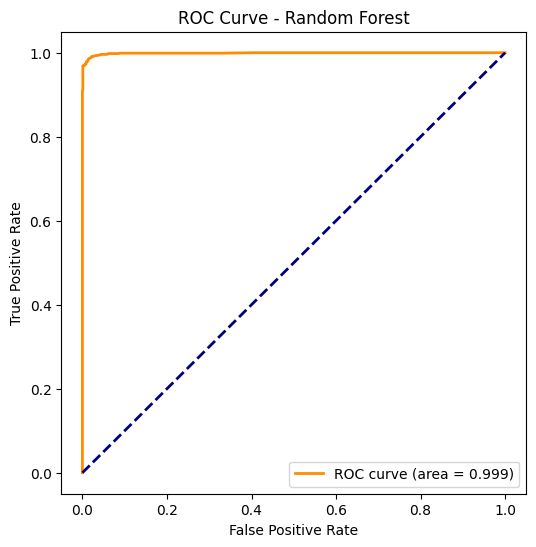

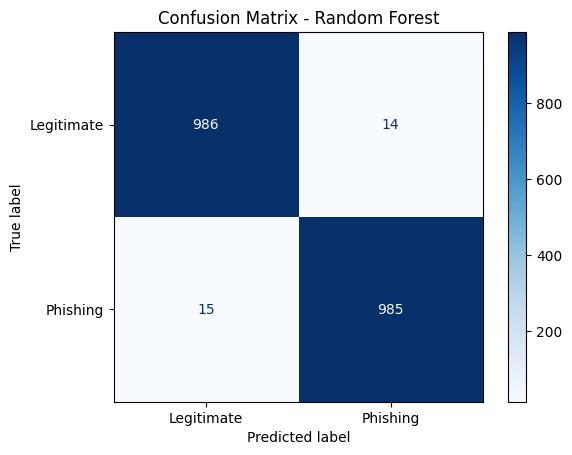

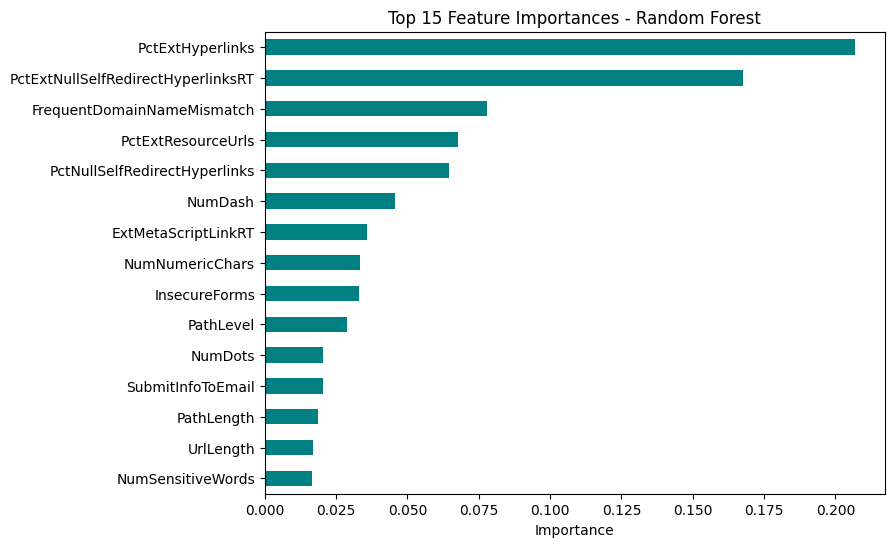

In [ ]:

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# 2. Load dataset
DATA_PATH = "/kaggle/input/phishing/Phishing_Legitimate_full.csv"   # <-- update path if needed
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("Columns:", df.columns[:10], "...")


SAMPLE_SIZE = 20000
if len(df) > SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=42)

# 3. Define target and features
label_col = "CLASS_LABEL"
y = df[label_col]
X = df.drop(columns=["id", label_col], errors="ignore")


X = X.select_dtypes(include=[np.number]).fillna(0)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5. Train models
# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

# Gradient Boosting
gb = HistGradientBoostingClassifier(max_iter=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_proba = gb.predict_proba(X_test)[:, 1]

# 6. Evaluation
def show_results(name, y_true, y_pred, y_proba):
    print(f"\n📊 {name} Results")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))

show_results("Logistic Regression", y_test, lr_pred, lr_proba)
show_results("Random Forest", y_test, rf_pred, rf_proba)
show_results("Gradient Boosting", y_test, gb_pred, gb_proba)

# 7. Visualization

## ROC Curve (Random Forest)
fpr, tpr, thresholds = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate","Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

## Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15)[::-1].plot(kind="barh", color="teal")
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()
